# Fast inference example using VLLM + Runpod.io
This notebook is a companion to the following paper, please cite it accordingly: 
- [de Kok (2024) - SSRN](https://papers.ssrn.com/abstract=4429658)


**Author:** [Ties de Kok](https://www.tiesdekok.com/)

**Important:** please read the instructions in the corresponding `readme.md` file for the setup instructions.

----
# Runpod.io setup
----

**Step 1:** Make an account on https://www.runpod.io/ 

**Step 2:** Start a pod
1. Go to Pods and click Deploy
2. Select the GPU type you want and how many. 
    - For this example I will get a single RTX 4090.
3. Check the "Pod Template" and make sure it says "RunPod PyTorch X.XX". 
    - For this example I will select: `runpod/pytorch:2.2.0-py3.10-cuda12.1.1-devel-ubuntu22.04`
4. Make sure your pod has sufficient storage capacity.
    - Click "Edit Template", and I will set the container disk to 50GB and the volume disk to 250GB.
5. Make sure "Start Jupyter Notebook" is ticked. --> Click "Deploy On-Demand" to start the pod.    
    
    
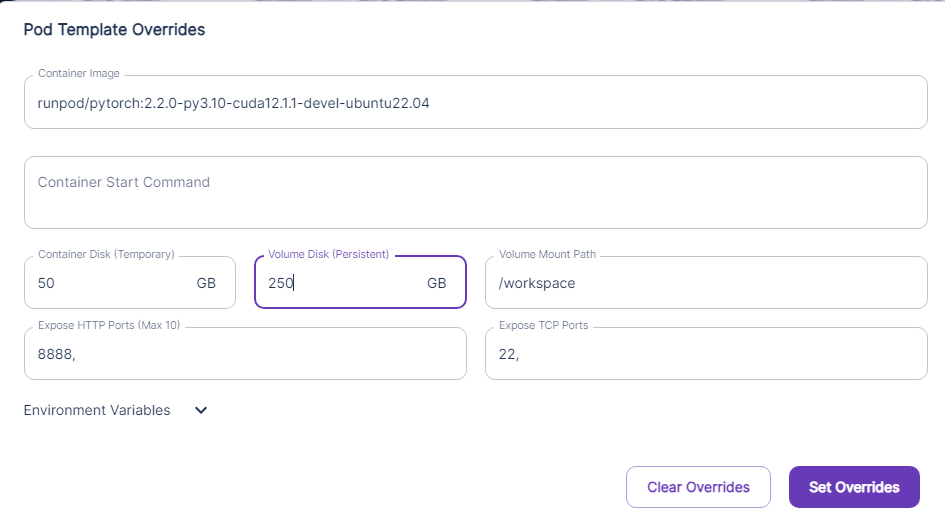 
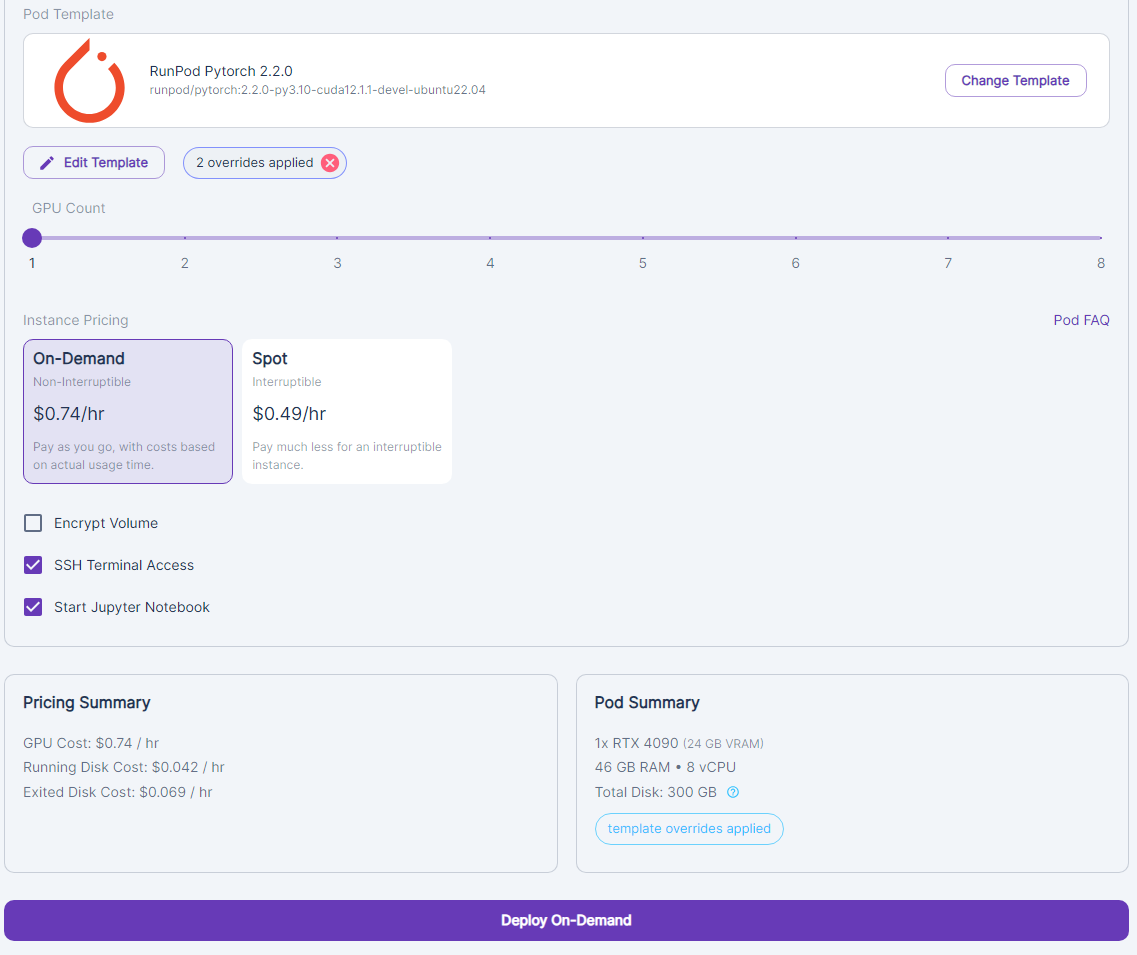 

**Step 3**: Connect to the pod
1. Go to Pods and click on the purple arrow to expand the pod you want to connect to. 
2. Once it states "running" --> click the connect button and select "Connect to Jupyter Lab".
3. You should see Jupyter Lab open up. You are now connected!

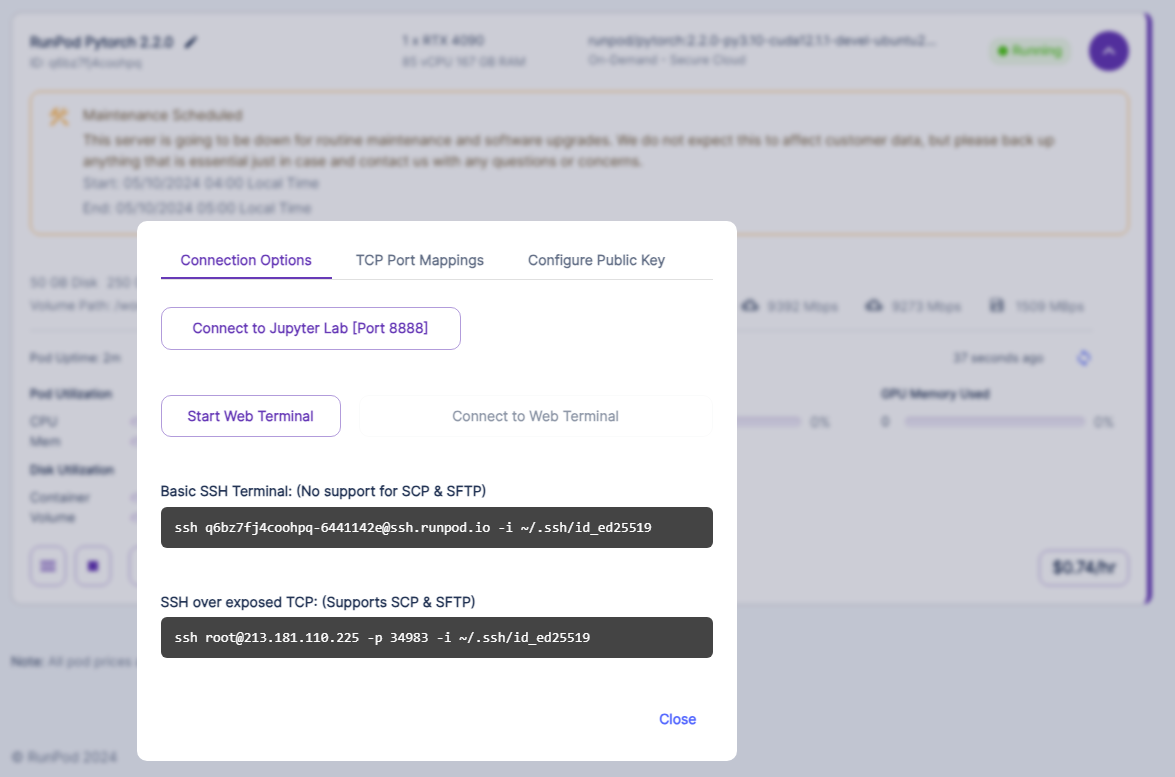 

**Step 4:** Install the VLLM dependencies
1. In Jupyter Lab click on "Terminal" (or click the blue + and then Terminal)

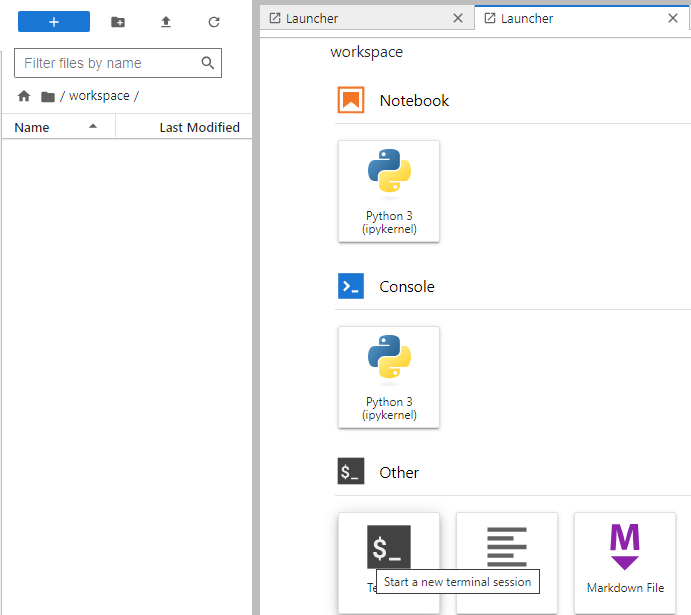

2. In the terminal window run the following commands to install VLLM (this will take a few minutes):
```bash
pip install vllm
pip install flash-attn
```

**Step 5:** Tranfer your data / models/ code to the Pod
1. Option 1 - use the upload feature of Jupyter Lab (this is easy, but slow for big files):

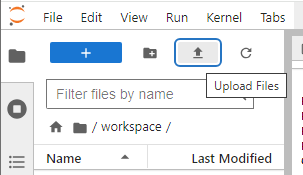

2. Option 2 - use WinSCP + the SSH connection (this is faster and easy when set up, but requires knowledge of SSH keys)

3. Option 3 - the pods are internet connected, so things like Dropbox links etc. can work well with `wget`

4. Option 4 - sync your pods with something like Backblaze, Amazon S3, etc. 

**Step 6:** Run your inference by either upload this notebook or copying the code

**Step 7:** When you are done
1. Download any data you do not wish to lose. E.g., by downloading it through Jupyter Lab:

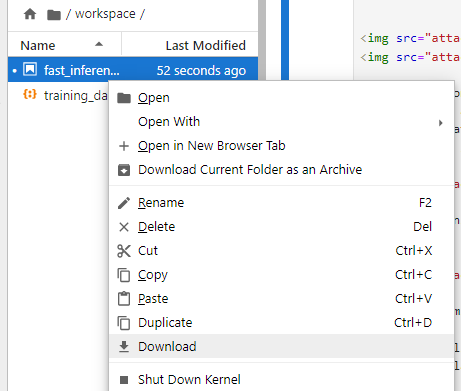

2. Go to the Runpod.io interface and click the stop button:

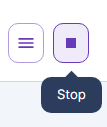

3. Once the pod is stopped, fully delete it (as you are still charged a small amount for storage, even when stopped)

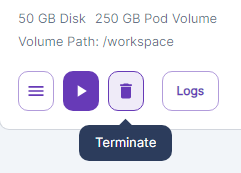

----
# Run inference
---

#### Imports

In [1]:
import os, sys, re, random, copy, json
from pathlib import Path
from vllm import LLM, SamplingParams

### Prepare the data

##### Download some sample data

See above for ways to get your own data to the Pod.

In [2]:
!wget https://raw.githubusercontent.com/TiesdeKok/chatgpt_paper/main/code_examples/vast_ai/data/training_data.jsonl

--2024-05-04 14:32:29--  https://raw.githubusercontent.com/TiesdeKok/chatgpt_paper/main/code_examples/vast_ai/data/training_data.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11265 (11K) [text/plain]
Saving to: ‘training_data.jsonl’

training_data.jsonl 100%[===================>]  11.00K  --.-KB/s    in 0.001s  

2024-05-04 14:32:29 (12.6 MB/s) - ‘training_data.jsonl’ saved [11265/11265]



##### Load the example data

Note that I am re-using the data from the training example, so the below is just to create some example prompts.

In [5]:
data = []
with open("training_data.jsonl", "r") as f:
    for line in f.readlines():
        data.append(json.loads(line))

In [42]:
prompt_template = """
Task: extract all the words that are in <> from the text below. Return the result as a JSON list.

Text:
This is <a> text with <words> in brackets.
JSON=["a", "words"]

Text:
{}
JSON=
""".strip()

In [43]:
prompt_list = []
for item in data:
    text = item["INSTRUCTION"].replace("Text:\n", "").replace("\n####\n", "")
    prompt = prompt_template.format(text)
    prompt_list.append(prompt)

In [44]:
print(prompt_list[0])

Task: extract all the words that are in <> from the text below. Return the result as a JSON list.

Text:
This is <a> text with <words> in brackets.
JSON=["a", "words"]

Text:
We expect the implementation of our new data-driven pricing strategy <to> result in a 5% <increase> in gross margin over the next two quarters.
JSON=


### Load the model

Note, VLLM will automatically download models from Huggingface Hub the first time you load a new model. 

If you want to use your own model (e.g., after fine-tuning) you can download the model to your pod yourself and instead provide the folder path.

In [25]:
llm = LLM(model="microsoft/phi-2", tensor_parallel_size=1) ## Think of "tensor_parallel_size" as "number_of_gpus"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

INFO 05-04 14:37:37 llm_engine.py:98] Initializing an LLM engine (v0.4.1) with config: model='microsoft/phi-2', speculative_config=None, tokenizer='microsoft/phi-2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0)


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

INFO 05-04 14:37:40 utils.py:608] Found nccl from library /root/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 05-04 14:37:40 selector.py:28] Using FlashAttention backend.
INFO 05-04 14:37:41 weight_utils.py:193] Using model weights format ['*.safetensors']


model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

INFO 05-04 14:39:33 model_runner.py:173] Loading model weights took 5.1933 GB
INFO 05-04 14:39:34 gpu_executor.py:119] # GPU blocks: 3144, # CPU blocks: 819
INFO 05-04 14:39:35 model_runner.py:976] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-04 14:39:35 model_runner.py:980] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-04 14:39:41 model_runner.py:1057] Graph capturing finished in 6 secs.


### Run inference

In [45]:
sampling_params = SamplingParams(temperature=0, max_tokens = 250, stop = ["<|end|>"])

In [46]:
%%time
outputs = llm.generate(prompt_list, sampling_params)

Processed prompts: 100%|██████████| 50/50 [00:00<00:00, 111.82it/s]

CPU times: user 465 ms, sys: 12.1 ms, total: 477 ms
Wall time: 475 ms


### Results

In [49]:
for i, item in enumerate(outputs):
    print(item.prompt, end = "\n\n")

    print("Completion: ", item.outputs[0].text.strip())

    if i == 3:
        break
    
    print("\n----\n")

Task: extract all the words that are in <> from the text below. Return the result as a JSON list.

Text:
This is <a> text with <words> in brackets.
JSON=["a", "words"]

Text:
We expect the implementation of our new data-driven pricing strategy <to> result in a 5% <increase> in gross margin over the next two quarters.
JSON=

Completion:  ["to", "increase"]

----

Task: extract all the words that are in <> from the text below. Return the result as a JSON list.

Text:
This is <a> text with <words> in brackets.
JSON=["a", "words"]

Text:
Over the <past> year, we have focused on strengthening our balance sheet, resulting in a <5%> reduction in debt levels.
JSON=

Completion:  ["past", "5%"]

----

Task: extract all the words that are in <> from the text below. Return the result as a JSON list.

Text:
This is <a> text with <words> in brackets.
JSON=["a", "words"]

Text:
We <are> in the early <stages> of exploring potential acquisition opportunities that could strengthen our market position a